## Modelisation
A partir de maintenant nous souhaitons estimer le prix d'un bien à partir de ces caractéristiques.
On va d'abord estimer le prix au m².
Puis on regardera le logPrix qui était mieux réparti que le prix.

In [119]:
import numpy as np
import pandas as pd

df = pd.read_csv('preprocessing_2.csv')

#Ajout du prix au m² que l'on devra prédire
#Nous choisissons cette variable et non le prix car le prix est énormement dépendant de la surface et le modèle concentrerait trop sur cette relation
df['prix du m2'] = df['prix'] / df['surface']

df=df.drop(columns=["prix"])

df

,id,Type,Nb_piece,loc,surface,loc1,loc2,loc3,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y,prix du m2
0,apimo-85473173,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),29,Châtelet - Les Halles,Quartier Les Halles,75001,48.861651,2.347013,48.862373,2.345313,48.864614,2.334396,12551.724138
1,hektor-Les-4-Quartiers-383,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),23,Châtelet - Les Halles,Quartier Les Halles,75001,48.861651,2.347013,48.862373,2.345313,48.864614,2.334396,13086.956522
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,Palais Royal,Quartier du Palais Royal,75001,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396,23490.566038
3,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,Saint-Germain,NaN,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951,13518.518519
4,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,Vendôme,Quartier Vendôme,75001,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396,17761.194030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10096,apimo-83966258,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),22,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,10863.636364
10097,ag755800-412953689,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),35,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,6845.714286
10098,century-21-202_480_27885,Appartement,3,75020 Paris 20e (Plaine - Lagny),63,Plaine,Quartier de Charonne,75020,48.850152,2.402190,48.855145,2.397638,48.865042,2.398929,8555.555556
10099,netty-company34605jrw-appt-3212,Appartement,1,75020 Paris 20e (Gambetta),27,Gambetta,Quartier du Père-Lachaise,75020,48.864933,2.398054,48.863752,2.395302,48.865042,2.398929,7962.962963


In [120]:
df['loc2_x'] = df['loc2_x'].fillna(df['loc1_x'])
df['loc2_y'] = df['loc2_y'].fillna(df['loc1_y'])
df['loc2']= df['loc2'].fillna(df['loc1'])

In [121]:
prix_moyen_par_zone = df.groupby('loc1')['prix du m2'].mean().reset_index() # on définit la moyenne du prix du m2 par zone
prix_moyen_par_zone.rename(columns={'prix du m2': 'moyenne_prix_m2_par_loc1'}, inplace=True) # afin de faciliter le merge qui arrive

df = df.merge(prix_moyen_par_zone, on='loc1', how='left') # on merge sur le dataframe initial pour avoir, pour chaque bien, la moyenne du prix du m2 de sa zone

ratio_seuil = 0.6 # on choisit arbitrairement 60%

df['seuil_prix_m2'] = ratio_seuil * df['moyenne_prix_m2_par_loc1'] # on calcule pour chaque bien (chaque zone) la valeur minimale du prix du m2 autorisée

print(f"Nombre de df avec 'prix du m²' au moins {(1 - ratio_seuil)*100}% inférieur à la moyenne de leur loc1 : {df[df['prix du m2'] <= df['seuil_prix_m2']].shape[0]}")

df = df[df['prix du m2'] > df['seuil_prix_m2']] # on conserve les biens qui ont un prix du m2 suffisant comparativement à leur zone

df.drop(['moyenne_prix_m2_par_loc1', 'seuil_prix_m2'], axis=1, inplace=True) # on supprime les colonnes temporaires pour améliorer la visibilité

df.loc[df["prix du m2"].idxmin()]

df = df[df['Type'] != "Loft/atelier/surface"]
df = df.drop(index = df['prix du m2'].idxmax())
df = df[df['Nb_piece']<9]



Nombre de df avec 'prix du m²' au moins 40.0% inférieur à la moyenne de leur loc1 : 160


In [122]:
# Garder ce qui nous intéresse
# On suprimme l'id car inutile pour estimer le prix
df = df.drop(columns=['id'])
# On suprimme supprime les localisations  dans un premier temps car je suppose l'information inclus dans les coordonnées
df = df.drop(columns=["loc","loc1","loc2","loc3"])
df

,Type,Nb_piece,surface,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y,prix du m2
0,Appartement,1,29,48.861651,2.347013,48.862373,2.345313,48.864614,2.334396,12551.724138
1,Appartement,1,23,48.861651,2.347013,48.862373,2.345313,48.864614,2.334396,13086.956522
2,Appartement,5,106,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396,23490.566038
3,Studio,1,27,48.856553,2.333331,48.856553,2.333331,48.850433,2.332951,13518.518519
4,Appartement,2,67,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396,17761.194030
...,...,...,...,...,...,...,...,...,...,...
10096,Appartement,1,22,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,10863.636364
10097,Appartement,1,35,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,6845.714286
10098,Appartement,3,63,48.850152,2.402190,48.855145,2.397638,48.865042,2.398929,8555.555556
10099,Appartement,1,27,48.864933,2.398054,48.863752,2.395302,48.865042,2.398929,7962.962963


In [123]:
#Encod the sting variables
# One hot encoding seems better for variables with a few values taken and now cardinality

df_encoded = pd.get_dummies(df, columns=['Type'], prefix='Type',dtype=float)
df_encoded

,Nb_piece,surface,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y,prix du m2,Type_Appartement,Type_Duplex,Type_Maison,Type_Studio
0,1,29,48.861651,2.347013,48.862373,2.345313,48.864614,2.334396,12551.724138,1.0,0.0,0.0,0.0
1,1,23,48.861651,2.347013,48.862373,2.345313,48.864614,2.334396,13086.956522,1.0,0.0,0.0,0.0
2,5,106,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396,23490.566038,1.0,0.0,0.0,0.0
3,1,27,48.856553,2.333331,48.856553,2.333331,48.850433,2.332951,13518.518519,0.0,0.0,0.0,1.0
4,2,67,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396,17761.194030,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10096,1,22,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,10863.636364,1.0,0.0,0.0,0.0
10097,1,35,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,6845.714286,1.0,0.0,0.0,0.0
10098,3,63,48.850152,2.402190,48.855145,2.397638,48.865042,2.398929,8555.555556,1.0,0.0,0.0,0.0
10099,1,27,48.864933,2.398054,48.863752,2.395302,48.865042,2.398929,7962.962963,1.0,0.0,0.0,0.0


In [124]:
# Let's normalize the variable so to reduce the impact of the scale of the input features of the model (SVM for now)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Binary variables don't need to be normalized
numerical_cols = ["Nb_piece", "surface", "prix du m2", "loc1_x", "loc1_y", "loc2_x", "loc2_y", "loc3_x", "loc3_y"]

df_standardized = df_encoded.copy()
df_standardized[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])
df_standardized

,Nb_piece,surface,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y,prix du m2,Type_Appartement,Type_Duplex,Type_Maison,Type_Studio
0,-1.192424,-0.747973,-0.001478,0.175332,0.008113,0.047721,0.095189,-0.150918,0.405852,1.0,0.0,0.0,0.0
1,-1.192424,-0.877977,-0.001478,0.175332,0.008113,0.047721,0.095189,-0.150918,0.558203,1.0,0.0,0.0,0.0
2,1.537312,0.920415,0.090627,-0.100238,0.110360,-0.167323,0.095189,-0.150918,3.519532,1.0,0.0,0.0,0.0
3,-1.192424,-0.791308,-0.244376,-0.173489,-0.258677,-0.230418,-0.601523,-0.187944,0.681045,0.0,0.0,0.0,1.0
4,-0.509990,0.075387,0.248566,-0.295412,0.215634,-0.341429,0.095189,-0.150918,1.888698,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10096,-1.192424,-0.899645,-0.026329,1.373500,0.071340,1.208147,0.116197,1.502314,-0.074653,1.0,0.0,0.0,0.0
10097,-1.192424,-0.617969,-0.026329,1.373500,0.071340,1.208147,0.116197,1.502314,-1.218331,1.0,0.0,0.0,0.0
10098,0.172444,-0.011282,-0.549309,1.582090,-0.323193,1.262356,0.116197,1.502314,-0.731635,1.0,0.0,0.0,0.0
10099,-1.192424,-0.791308,0.154844,1.476639,0.071340,1.208147,0.116197,1.502314,-0.900313,1.0,0.0,0.0,0.0


In [125]:
from sklearn.model_selection import cross_val_score, KFold

# Séparation des inputs et outputs
X = df_standardized.drop(columns=["prix du m2"])
y = df_standardized["prix du m2"]

# Validation croisée avec 10 folds pour réduire l'aléatoire du splitting
kf = KFold(n_splits=10, shuffle=True)

#Au cas ou, nous créons une partition
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Testons différents models

In [126]:
#Imports for metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Création des métrics
from sklearn.metrics import make_scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

In [127]:
#Linear regression
from sklearn.linear_model import LinearRegression
modelLR = LinearRegression()

# Calcul des scores
mae_scores = cross_val_score(modelLR, X, y, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(modelLR, X, y, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(modelLR, X, y, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

MAE moyen : 0.639968507925769
MSE moyen : 0.8937553625620132
R² moyen : 0.10211287283138995
Écart-type R² : 0.025466201840686827


In [128]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

modelRFR = RandomForestRegressor()

# Calcul des scores
mae_scores = cross_val_score(modelRFR, X, y, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(modelRFR, X, y, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(modelRFR, X, y, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

MAE moyen : 0.42514781412328817
MSE moyen : 0.47744782327425506
R² moyen : 0.5324982405485207
Écart-type R² : 0.04535360377928956


In [129]:
#SVM
from sklearn.svm import SVR

modelSVR = SVR()

# Calcul des scores
mae_scores = cross_val_score(modelSVR, X, y, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(modelSVR, X, y, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(modelSVR, X, y, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

MAE moyen : 0.47980701223826483
MSE moyen : 0.6600168787407381
R² moyen : 0.3422447759208141
Écart-type R² : 0.045378836627352495


In [130]:
!pip install xgboost

In [131]:
#Puisque l'arbre semble le plus prométeur, testons une verion boostée
from xgboost import XGBRegressor

modelXGB = XGBRegressor(
    n_estimators=100,      # Nombre d'arbres
    learning_rate=0.1,     # Taux d'apprentissage
    max_depth=5,           # Profondeur maximale des arbres
)

# Calcul des scores
mae_scores = cross_val_score(modelXGB, X, y, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(modelXGB, X, y, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(modelXGB, X, y, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

MAE moyen : 0.43993987889905367
MSE moyen : 0.46872770528198
R² moyen : 0.527849437715852
Écart-type R² : 0.025578866843289305


In [140]:
#Ce n'est pas mieux que l'arbre classique donc essayons d'optimiser les paramêtres
from sklearn.model_selection import RandomizedSearchCV

# Définir une grille de paramêtres
param_dist = {
    'n_estimators': np.linspace(50, 500, 10).astype(int),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': [6,7,8,9,10,11,12],
}

#Model de recherche de paramêtres
grid_search  = RandomizedSearchCV(
    estimator=modelXGB,
    param_distributions=param_dist,
    n_iter=50,                          # Nombre d'itérations
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

grid_search .fit(X, y)

best_params = grid_search .best_params_
final_model = XGBRegressor(**best_params)

# Calcul des scores
mae_scores = cross_val_score(final_model, X, y, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(final_model, X, y, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(final_model, X, y, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
MAE moyen : 0.42782029963630386
MSE moyen : 0.4497253317805597
R² moyen : 0.533559372242127
Écart-type R² : 0.0626339348858112


In [141]:
best_params

{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.07333333333333333}

Etrangement, le XGboost n'est pas meilleur que l'arbre classique.
Je n'ai surement pas réussi à trouver le meilleur paramêtre durant mes divers essais.
Les résultats sont plutôt mauvais puisque l'on travail sur des valeurs normalisées, 0.48594887909663703 de MAE est élévé

### Visualisation

In [134]:
best_model=modelRFR

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
best_model.fit(X_train,y_train)
y_predict=best_model.predict(X_test)

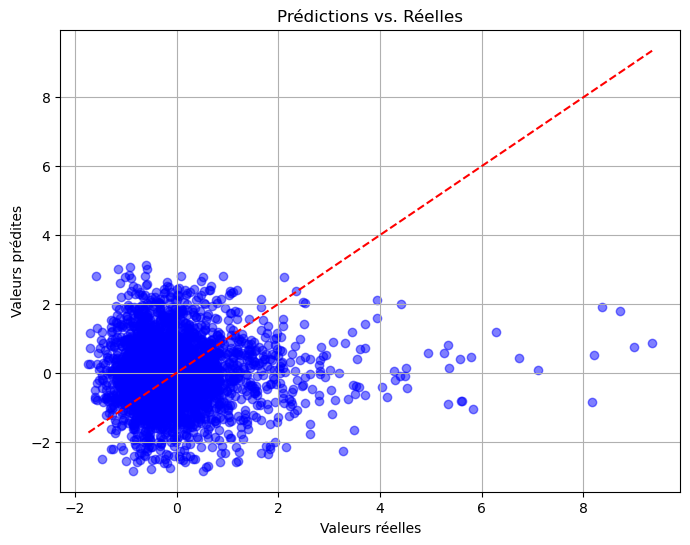

In [136]:
import matplotlib.pyplot as plt

# Graphique de Prédictions vs. Réelles (scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne y=x
plt.title("Prédictions vs. Réelles")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.grid(True)
plt.show()

C'est assez catastrophique. Les predictions ne sont pas alignées avec les valeurs réelles. De plus les valeurs extrèmes sont toujours mals prédites. C'est comm si notre prédiction était du bruit

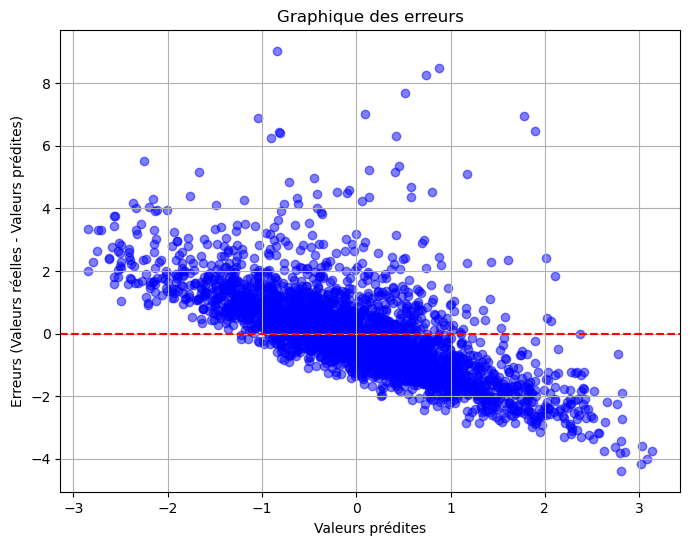

In [137]:
# Calcul des erreurs
errors = y_test - y_pred

# Graphique des erreurs
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, errors, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Ligne des erreurs nulles
plt.title("Graphique des erreurs")
plt.xlabel("Valeurs prédites")
plt.ylabel("Erreurs (Valeurs réelles - Valeurs prédites)")
plt.grid(True)
plt.show()

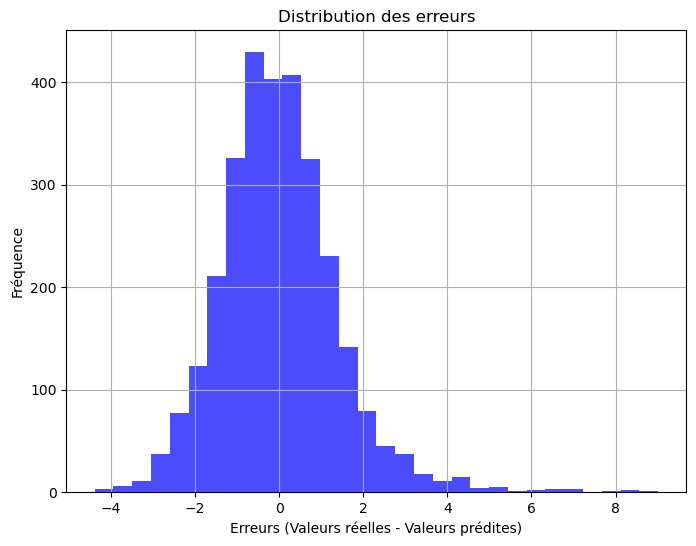

In [138]:
# Histogramme des erreurs
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='blue', alpha=0.7)
plt.title("Distribution des erreurs")
plt.xlabel("Erreurs (Valeurs réelles - Valeurs prédites)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

L'erreur reste gaussienne centrée donc il n'y a pas de biais

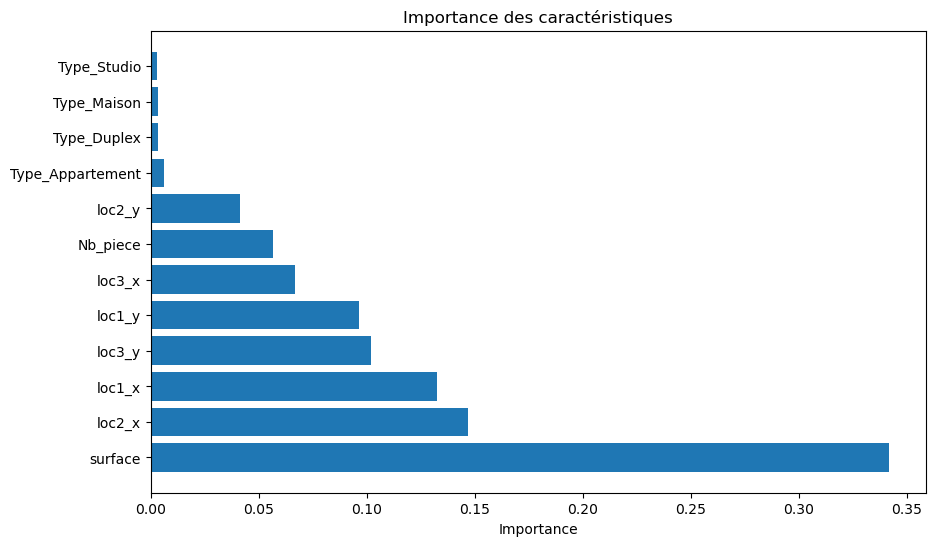

In [139]:
# Importance des caractéristiques pour Random Forest
importances = modelRFR.feature_importances_

# Trier les importances
indices = np.argsort(importances)[::-1]

# Visualisation
plt.figure(figsize=(10, 6))
plt.title("Importance des caractéristiques")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel("Importance")
plt.show()

La surface reste la caractéristique prépondérante malgrès le fait que l'on essaye de prédire le prix/m²
Cependant elle accapare une moins grande part de la prédiction que si l'on esye de prédire jutste le prix

#### Dans le cas ou l'on veut prédire le log(prix) , le meilleur modèle était le Random Forest

In [70]:
df_prix = pd.read_csv('preprocessing_2.csv')
df_prix['prix du m2'] = df_prix['prix'] / df_prix['surface']
df_prix["prix"]=np.log(df_prix["prix"])
df_prix['loc2_x'] = df_prix['loc2_x'].fillna(df_prix['loc1_x'])
df_prix['loc2_y'] = df_prix['loc2_y'].fillna(df_prix['loc1_y'])
df_prix['loc2']= df_prix['loc2'].fillna(df_prix['loc1'])
prix_moyen_par_zone = df_prix.groupby('loc1')['prix du m2'].mean().reset_index() # on définit la moyenne du prix du m2 par zone
prix_moyen_par_zone.rename(columns={'prix du m2': 'moyenne_prix_m2_par_loc1'}, inplace=True) # afin de faciliter le merge qui arrive
df_prix = df_prix.merge(prix_moyen_par_zone, on='loc1', how='left') # on merge sur le dataframe initial pour avoir, pour chaque bien, la moyenne du prix du m2 de sa zone
ratio_seuil = 0.6 # on choisit arbitrairement 60%
df_prix['seuil_prix_m2'] = ratio_seuil * df_prix['moyenne_prix_m2_par_loc1'] # on calcule pour chaque bien (chaque zone) la valeur minimale du prix du m2 autorisée
df_prix = df_prix[df_prix['prix du m2'] > df_prix['seuil_prix_m2']] # on conserve les biens qui ont un prix du m2 suffisant comparativement à leur zone
df_prix.drop(['moyenne_prix_m2_par_loc1', 'seuil_prix_m2'], axis=1, inplace=True) # on supprime les colonnes temporaires pour améliorer la visibilité
df_prix.loc[df_prix["prix du m2"].idxmin()]
df_prix = df_prix[df_prix['Type'] != "Loft/atelier/surface"]
df_prix = df_prix.drop(index = df_prix['prix du m2'].idxmax())
df_prix = df_prix[df_prix['Nb_piece']<9]
df_prix=df_prix.drop(columns=['prix du m2'])
df_prix = df_prix.drop(columns=['id'])
df_prix = df_prix.drop(columns=["loc","loc1","loc2","loc3"])
df_encoded_prix = pd.get_dummies(df_prix, columns=['Type'], prefix='Type',dtype=float)


# Separation of inputs and outputs
X_prix = df_encoded_prix.drop(columns=["prix"])
y_prix = df_encoded_prix["prix"]

# Standardize the input features
scaler_prix_X = StandardScaler()
numerical_cols = ["Nb_piece", "surface", "loc1_x", "loc1_y", "loc2_x", "loc2_y", "loc3_x", "loc3_y"]
X_prix[numerical_cols] = scaler_prix_X.fit_transform(X_prix[numerical_cols])

scaler_prix_y = StandardScaler()
y_prix=scaler_prix_y.fit_transform(y_prix.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_prix, y_prix, test_size=0.3)

best_model=modelRFR

In [71]:
# Calcul des scores
mae_scores = cross_val_score(best_model, X_prix, y_prix, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(best_model,  X_prix, y_prix, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(best_model,  X_prix, y_prix, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

MAE moyen : 0.1632025275284671
MSE moyen : 0.05342653449314191
R² moyen : 0.9467812664824239
Écart-type R² : 0.004329530000053218


In [73]:
best_model.fit(X_train,y_train)
y_pred=best_model.predict(X_test)

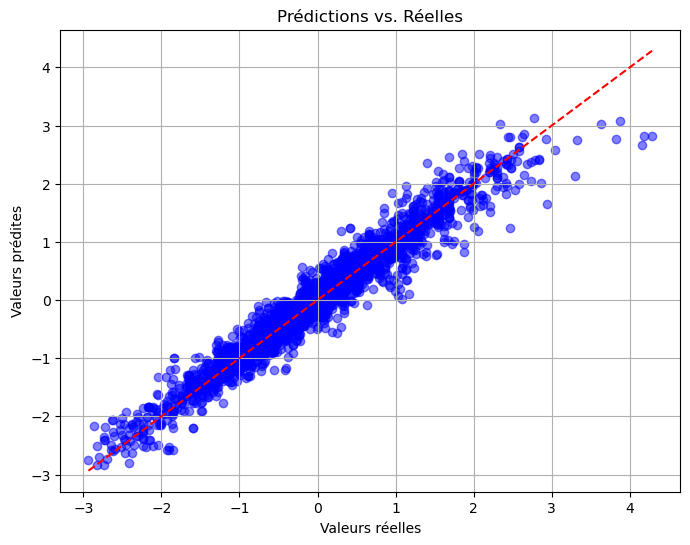

In [74]:
import matplotlib.pyplot as plt

# Graphique de Prédictions vs. Réelles (scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne y=x
plt.title("Prédictions vs. Réelles")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.grid(True)
plt.show()

In [77]:
# Reverse the scaling for the test target values
y_test_reel = scaler_prix_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Reverse the scaling for the predicted values
y_pred_reel = scaler_prix_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

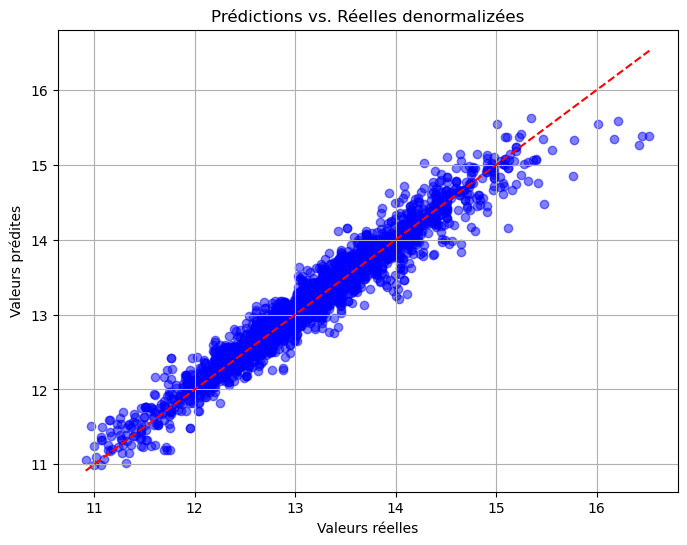

In [79]:
# Graphique de Prédictions vs. Réelles (scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reel, y_pred_reel, color='blue', alpha=0.5)
plt.plot([min(y_test_reel), max(y_test_reel)], [min(y_test_reel), max(y_test_reel)], color='red', linestyle='--')  # Ligne y=x
plt.title("Prédictions vs. Réelles denormalizées")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.grid(True)
plt.show()

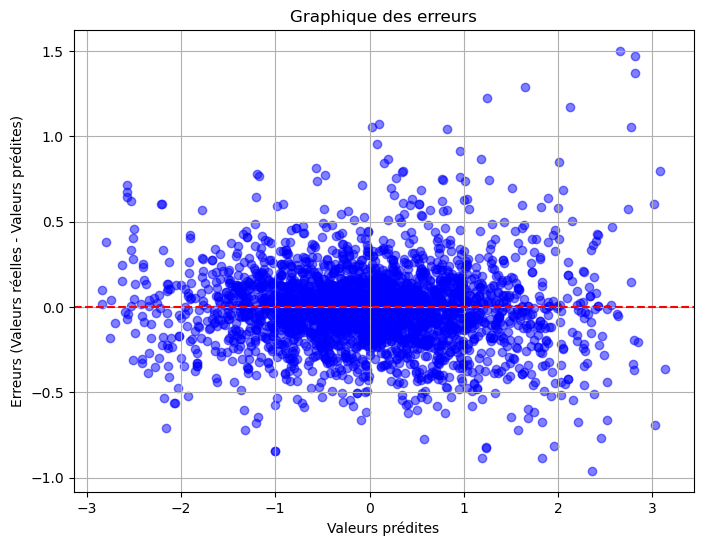

In [80]:
# Calcul des erreurs
errors = y_test - y_pred

# Graphique des erreurs
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, errors, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Ligne des erreurs nulles
plt.title("Graphique des erreurs")
plt.xlabel("Valeurs prédites")
plt.ylabel("Erreurs (Valeurs réelles - Valeurs prédites)")
plt.grid(True)
plt.show()

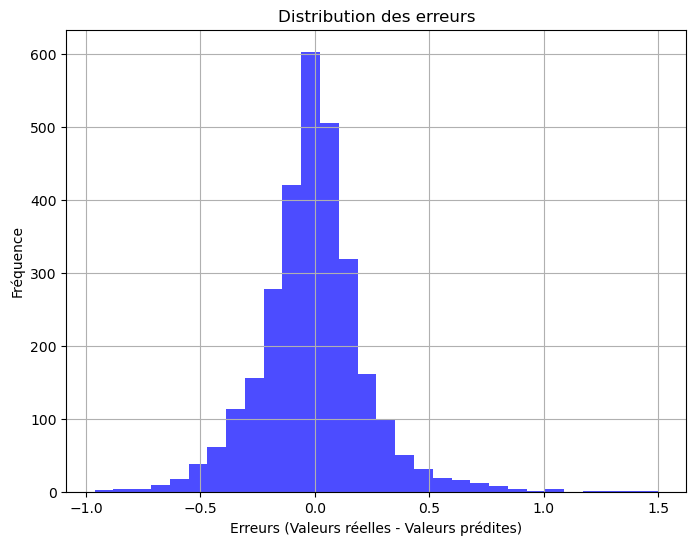

In [81]:
# Histogramme des erreurs
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='blue', alpha=0.7)
plt.title("Distribution des erreurs")
plt.xlabel("Erreurs (Valeurs réelles - Valeurs prédites)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

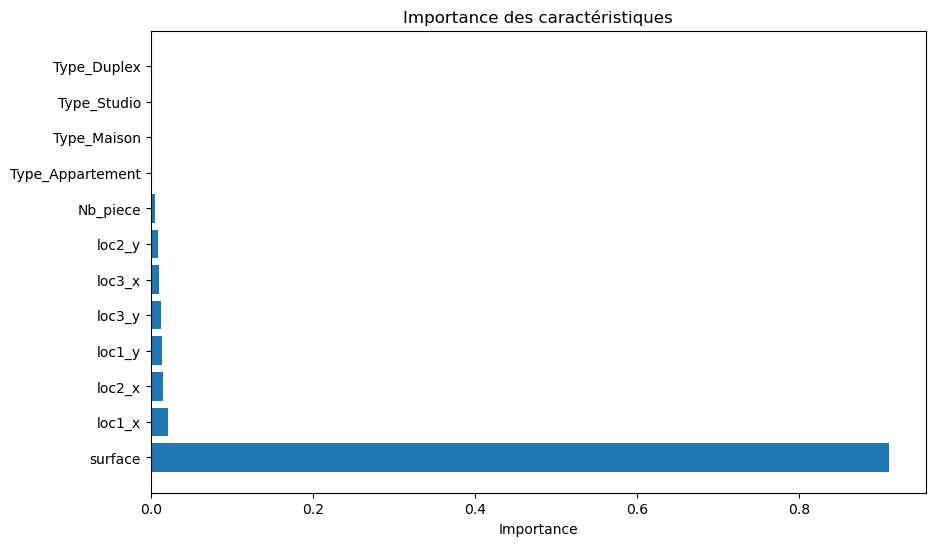

In [82]:
# Importance des caractéristiques pour Random Forest
importances = modelRFR.feature_importances_

# Trier les importances
indices = np.argsort(importances)[::-1]

# Visualisation
plt.figure(figsize=(10, 6))
plt.title("Importance des caractéristiques")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel("Importance")
plt.show()